## Summary of the notebook
* There were three dataframes that were created during the transformation process <br>
viz. trans_train_df(transformed train data),trans_merch_df(transformed merchant data),trans_hist_df(transformed historical data)
* Dropped a few duplicate columns and unwanted columns with low correlation with the target variable.
* The total number of columns obtained after performing the above operations = 589
* [Action plan of imputation](#action_plan_for_imputation)
* [Missing Values percentage and analysis](#percentage_of_missing_values)
* [Initial dropping of features](#initial_dropping_of_features)
* [Modification_in_imputation_strategy](#modification_in_imputation_strategy)
* [Median,Mode based imputation](#median_mode_based_imputation)
* [Model based imputation](#model_based_imputation)
* [Mix of median,mode and model based imputation](#mixed_imputation)
* [Comparing_performances](#comparing_performances)
* [Final Analysis](#final_analysis)

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse

In [3]:
## Importing all the necessary Imputers and Tree based models
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
## Creating a scoring function for RMSE as this is the metric used in the competition
def root_mean_squared_error(model,X,y_true):
  y_pred = model.predict(X)
  return np.sqrt(mse(y_true,y_pred))

In [6]:
## Importing all the required dataframes
trans_train_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/trans_train_df.pkl','rb'))
trans_merch_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/trans_merch_df.pkl','rb'))
trans_hist_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/trans_hist_df.pkl','rb'))

## Merging all the dataframes
trans_df = pd.merge(trans_train_df,trans_merch_df,on='card_id',how='inner')
trans_df = pd.merge(trans_df,trans_hist_df,on='card_id',how='inner')
trans_df.shape

(201917, 600)

In [8]:
## In the process of merging 
## identified few duplicate columns
## so dropping them.

trans_df = trans_df.loc[:,~trans_df.columns.duplicated()]
## These are some of the useless columns which 
## don't add much value to the model(identified during EDA)
## plus needs an additional conversion into one-hot or 
## label encoding. So dropping these features as well

cat_col_list = ['first_active_month','category_1_mode','category_3_mode','subsector_id_mode',
                'merchant_category_id_mode','category_4_mode', 'most_recent_sales_range_mode',
                'most_recent_purchases_range_mode','card_id']
trans_df.drop(cat_col_list,axis=1,inplace=True)
trans_df.shape

(201917, 589)

In [9]:
## Replacing all infinity values by nan's
trans_df.replace([np.inf,-np.inf],np.nan,inplace=True)

<a id='action_plan_for_imputation'></a>
## 2. Action plan for imputation
* Let's divide the features into three sets.
* Features with more than certain threshold of missing values,let's drop them.
* Feature with less than certain threshold of missing values, let's perform median or model based imputation.
* For rest of the features let's do model based imputation.

In [10]:
## Dividing the dataset into train and target
X_train = trans_df.drop(['target'],axis=1)
y_train = trans_df['target']
X_train.shape

(201917, 588)

<a id="percentage_of_missing_values"></a>
## 3. Identifying thresholds for different imputation regions

In [11]:
## Forming a dataframe based on null counts in each of the feature
null_count_df = (X_train.isnull().sum()*100/X_train.shape[0]).reset_index().rename(columns = {0 : 'null_count'})
null_count_df.head()

,index,null_count
0,feature_1,0.0
1,feature_2,0.0
2,feature_3,0.0
3,feature_2_bin,0.0
4,feature_1_bin,0.0


Text(0.5, 1.0, 'Number of features vs percentage of missing values')

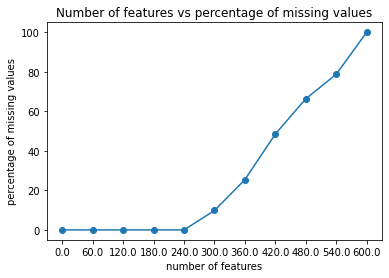

In [ ]:
## Plotting the number of features and percentage of missing values in them
percentile_10 = np.percentile(null_count_df['null_count'],q=[i for i in range(0,101,10)])
x_ticks = [i*(600/100) for i in range(0,101,10)]
plt.plot(x_ticks,percentile_10,marker='o') 
plt.xticks(x_ticks,x_ticks)
plt.ylabel('percentage of missing values')
plt.xlabel('number of features')
plt.title('Number of features vs percentage of missing values')

## Analysis:
* For upto 240 features we don't have missing values.
* Beyond that we can see a steep increase in the number of the missing values features.
* By looking at this plot I am thinking of dividing the missing values into three regions.

* Plan in first iteration
  * No-Null values
  * Median Imputation features with missing values greater than 0  and less than 25.
  * Model based imputation for 25 to 66 percentile missing values.
  * Elimination of remaining features.

* Plan after third iteration 
  * After several parameter tuning and realizing the RAM and core capacities finally decided on dividing the regions on following thresholds.
  * No-Null values.
  * mean_imputation = 0-50
  * model_imputation = 50-66
  * eliminate features with more than 66% missing values.

* Above thresholds were obtained from quantile values.

In [12]:
nnull_impute_feat = null_count_df[(null_count_df['null_count'] == 0)]['index'].values 
mean_impute_feat = null_count_df[(null_count_df['null_count'] > 0) & (null_count_df['null_count'] <= 50)]['index'].values
model_impute_feat = null_count_df[(null_count_df['null_count'] > 50) & (null_count_df['null_count'] <= 66)]['index'].values
eliminate_feat = null_count_df[(null_count_df['null_count'] > 66)]['index'].values

<a id = 'initial_dropping_of_features'></a>
### 3.1 Some General observations on the features to be eliminated

In [35]:
eliminate_feat

array(['np_amount_min_7_9', 'np_amount_min_8_10', 'np_amount_min_9_11',
       'np_amount_min_10_12', 'np_amount_min_11_13', 'np_amount_max_7_9',
       'np_amount_max_8_10', 'np_amount_max_9_11', 'np_amount_max_10_12',
       'np_amount_max_11_13', 'np_amount_mean_7_9', 'np_amount_mean_8_10',
       'np_amount_mean_9_11', 'np_amount_mean_10_12',
       'np_amount_mean_11_13', 'np_amount_sum_7_9', 'np_amount_sum_8_10',
       'np_amount_sum_9_11', 'np_amount_sum_10_12', 'np_amount_sum_11_13',
       'np_amount_std_6_8', 'np_amount_std_7_9', 'np_amount_std_8_10',
       'np_amount_std_9_11', 'np_amount_std_10_12', 'np_amount_std_11_13',
       'np_amount_min_12', 'np_amount_min_11', 'np_amount_min_10',
       'np_amount_min_13', 'np_amount_max_12', 'np_amount_max_11',
       'np_amount_max_10', 'np_amount_max_13', 'np_amount_mean_12',
       'np_amount_mean_11', 'np_amount_mean_10', 'np_amount_mean_13',
       'np_amount_sum_12', 'np_amount_sum_11', 'np_amount_sum_10',
       'np_amount

* As suggested by Raddar the most recent transactions are more important than the previous ones. <br>
* Even with the features in above section we can see that the purchase amount ratios and purchase amount aggregate functions for months beyond 7 and 8 contain a lot of null values.<br>
* So we are going to drop these features.
* Also we are going to look at which installment features are retained for model imputation.

In [ ]:
install = [i for i in range(0,13)]
install = install + [-1,999]

aggr_funcs = ['min','sum','max','std','mean']
install_feat=[]
for month in install:
  for func in aggr_funcs:
    install_feat.append('install_' + str(month) + "_" + str(func))

nnull_install_feat = [feat for feat in install_feat if feat not in eliminate_feat]
nnull_install_feat

['install_1_min',
 'install_1_sum',
 'install_1_max',
 'install_1_std',
 'install_1_mean',
 'install_2_min',
 'install_2_sum',
 'install_2_max',
 'install_2_mean',
 'install_3_min',
 'install_3_sum',
 'install_3_max',
 'install_3_mean']

* Installment features for a value beyond 3 contain a lot of null values.

<a id = "modification_in_imputation_strategy"></a>
## 3.2 Some modification in the plan
* After studying a bit about imputation.
* Let's try out a few strategies of imputing the data
  * imputing all data by median and mode imputation.(excluding the eliminate_features)
  * imputing all data by model based imputation.(excluding the eliminate_features)
  * imputing based on percentile of missing values.(a mix of both median and model based imputation,excluding eliminate features)
  * If time permits doing all of the above including eliminate features.(realized that we face RAM crash issues)
  


In [13]:
print("Length of not null features : ",len(nnull_impute_feat))
print("Length of mean imputation features : ",len(mean_impute_feat))
print("Length of model imputation features : ",len(model_impute_feat))
print("Length of initial feature set to work with : ",len(nnull_impute_feat) + len(mean_impute_feat) + len(model_impute_feat))

Length of not null features :  277
Length of mean imputation features :  136
Length of model imputation features :  45
Length of initial feature set to work with :  458


In [14]:
impute_features = list(nnull_impute_feat) + list(mean_impute_feat) + list(model_impute_feat)

In [15]:
X_features = X_train[impute_features].copy()
y_target = y_train.copy()
X_features.shape

(201917, 458)

In [ ]:
X_features.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('bool'), dtype('float32')],
      dtype=object)

<a id="median_mode_based_imputation"></a>
## 4. Median based imputation

### 4.1 Function for Median based imputation

In [16]:
def categoricalImputer(X_features):
  """
    Imputation of categorical features by most_frequent category
  """
  cat_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  return pd.DataFrame(cat_imputer.fit_transform(X_features),columns = X_features.columns)
  
def numericalImputer(X_features):
  """
    Imputation of numerical features by median value
  """
  num_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
  return pd.DataFrame(num_imputer.fit_transform(X_features),columns = X_features.columns)

def simpleImputerForAllCategories(X_features):
  
  """
    Performs median and mode based imputation for numerical and categorical features.
  """
  cat_cols = X_features.select_dtypes('int64').columns
  num_cols_1 = X_features.select_dtypes('float32').columns
  num_cols_2 = X_features.select_dtypes('float64').columns
  bool_cols = X_features.select_dtypes('bool').columns

  ## There is no imputer for boolean type of data 
  ## So converting it into 0's and 1's
  print("Converting boolean columns to 1's and 0's(int type)...")
  for col in bool_cols:
    X_features[col] = X_features[col].apply(lambda x : 1 if True else 0)

  cols_list = [cat_cols,num_cols_1,num_cols_2,bool_cols]
  imputed_features = []
  for cols in cols_list:
    if len(cols) > 0:
      if X_features[cols].dtypes.unique()[0] == 'int':
        print("Imputing for categorical variables...")
        imputed_features.append(categoricalImputer(X_features[cols]))
      else:
        print("Imputing for numerical variables...")
        imputed_features.append(numericalImputer(X_features[cols]))
    
  print("Features imputed...")
  return pd.concat(imputed_features,axis=1)
  


In [ ]:
## performing imputation and storing the pickle file
imputed_df = simpleImputerForAllCategories(X_features)
print(imputed_df.shape)
pickle.dump(imputed_df,open('gdrive/My Drive/ColabNotebooks/simple_imputed_df.pkl','wb'))

Converting boolean columns to 1's and 0's(int type)...
Imputing for categorical variables...
Imputing for categorical variables...
Features imputed...
(201917, 458)


In [17]:
## retrieving the imputed file
mean_imputed_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/simple_imputed_df.pkl','rb'))

### 4.2 Estimating the performance of imputation with a LGBM Regressor(because it's one of the fastest in performance)

In [18]:
lgbm = lgb.LGBMRegressor(verbose=2)
mean_imputed_score = cross_val_score(
        lgbm, mean_imputed_df, y_target, scoring=root_mean_squared_error,
        cv=3,verbose = 2,n_jobs=-1
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


array([3.74321604, 3.78516435, 3.79771682])

In [ ]:
## Sorry but I forgot to save it 
## So creating a list to use it for later purposes
mean_imputed_score = [3.74321604, 3.78516435, 3.79771682]

<a id="model_based_imputation"></a>
## 5. Model based Imputation

In [ ]:
## Features to be considered for imputation : All of the features containing null values
impute_feat = list(mean_impute_feat) + list(model_impute_feat)
X_features = X_features[impute_feat]
print("Shape of the DataFrame to be filled : ",X_features.shape)

Shape of the DataFrame to be filled :  (201917, 181)


### 5.1 DecisionTree based Imputation

In [ ]:
print("Creating Decision Tree Regressor...")
dt_regressor = DecisionTreeRegressor(max_features='sqrt',
                                     max_depth=5,
                                     random_state=0)
print("Creating Iterative Imputer...")
iterative_imputer = IterativeImputer(random_state = 0,
                                     estimator = dt_regressor,
                                     tol = 0.1,
                                     verbose=30)
print("Imputing features...")
dt_imputed_features = iterative_imputer.fit_transform(X_features)
dt_imputed_df = pd.DataFrame(dt_imputed_features,columns=X_features.columns)

Creating Decision Tree Regressor...
Creating Iterative Imputer...
Imputing features...
[IterativeImputer] Completing matrix with shape (201917, 181)
[IterativeImputer] Ending imputation round 1/10, elapsed time 288.80
[IterativeImputer] Change: 2951076040.948445, scaled tolerance: 400000025.6 
[IterativeImputer] Ending imputation round 2/10, elapsed time 577.59
[IterativeImputer] Change: 2926519621.044958, scaled tolerance: 400000025.6 
[IterativeImputer] Ending imputation round 3/10, elapsed time 868.37
[IterativeImputer] Change: 990947741.1861651, scaled tolerance: 400000025.6 
[IterativeImputer] Ending imputation round 4/10, elapsed time 1159.60
[IterativeImputer] Change: 5334464659.990709, scaled tolerance: 400000025.6 
[IterativeImputer] Ending imputation round 5/10, elapsed time 1451.19
[IterativeImputer] Change: 5391873328.865762, scaled tolerance: 400000025.6 
[IterativeImputer] Change: 666727572.8470494, scaled tolerance: 400000025.6 
[IterativeImputer] Ending imputation round

### 5.1.1 Dumping the dataframe imputed by Decision Trees

In [ ]:
pickle.dump(dt_imputed_df,open('gdrive/My Drive/ColabNotebooks/dt_imputed_df.pkl','wb'))

In [ ]:
dt_imputed_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/dt_imputed_df.pkl','rb'))

### 5.1.2 Estimating the performance of the imputed_df using LGBMRegressor 

In [ ]:
model_imputed_df = pd.concat([X_train[nnull_impute_feat],dt_imputed_df],axis=1)
model_imputed_df.shape

(201917, 458)

In [ ]:
lgbm_estimator = lgb.LGBMRegressor(verbose=10)
cross_val_score(
        lgbm_estimator,model_imputed_df, y_target,
        scoring=root_mean_squared_error,
        cv=3,verbose = 20,n_jobs=-1
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


array([3.73713822, 3.7875392 , 3.78328342])

In [20]:
dt_imputed_score = [3.73713822, 3.7875392 , 3.78328342]

<a id="mixed_imputation"></a>
### 6. Mixed Imputation
* Close the notebook and restart again to run below cells of code.

In [ ]:
simple_imputed_df = simpleImputerForAllCategories(X_features[mean_impute_feat])
print("Shape of Mean Imputed features : ",simple_imputed_df.shape)

print("***************Creating Extra Trees Regressor*****************")
et_regressor = ExtraTreesRegressor( n_estimators=10,
                                    verbose=10)
print("***************Creating Iterative Imputer*********************")
tree_based_imputer = IterativeImputer(estimator = et_regressor,
                                      max_iter = 3,
                                      verbose = 20)
print("***************Imputing features******************************")
tree_imputed_df = tree_based_imputer.fit_transform(X_features[model_impute_feat])

In [ ]:
tree_imputed_df = pd.DataFrame(tree_imputed_df,columns = model_impute_feat)

In [ ]:
print("***************Creating not null dataframe********************")
nnull_imputed_df = X_features[nnull_impute_feat].copy()

print("***************Concatenating dataframes***********************")
mixed_imputed_df = pd.concat([nnull_imputed_df,simple_imputed_df,tree_imputed_df],axis=1)
print("Mixed Imputed Dataframe shape : ",mixed_imputed_df.shape)
mixed_imputed_df.head()

***************Creating not null dataframe********************
***************Concatenating dataframes***********************
Mixed Imputed Dataframe shape :  (201917, 458)


,feature_1,feature_2,feature_3,feature_2_bin,feature_1_bin,first_active_day,first_active_wday,first_active_mm,first_active_year,category_4_nunique,most_recent_sales_range_nunique,most_recent_purchases_range_nunique,numerical_1_min,numerical_1_max,numerical_1_median,numerical_1_sum,numerical_1_std,numerical_2_min,numerical_2_max,numerical_2_median,numerical_2_sum,numerical_2_std,avg_sales_lag3_min,avg_sales_lag3_max,avg_sales_lag3_median,avg_sales_lag3_sum,avg_sales_lag3_std,avg_sales_lag6_min,avg_sales_lag6_max,avg_sales_lag6_median,avg_sales_lag6_sum,avg_sales_lag6_std,avg_sales_lag12_min,avg_sales_lag12_max,avg_sales_lag12_median,avg_sales_lag12_sum,avg_sales_lag12_std,avg_purchases_lag3_min,avg_purchases_lag3_median,avg_purchases_lag6_min,...,np_amount_mean_6_8,np_amount_sum_5_7,np_amount_sum_6_8,np_amount_std_3_5,np_amount_std_4_6,np_amount_std_5_7,np_amount_min_9,np_amount_min_8,np_amount_min_7,np_amount_max_9,np_amount_max_8,np_amount_max_7,np_amount_mean_9,np_amount_mean_8,np_amount_mean_7,np_amount_sum_9,np_amount_sum_8,np_amount_sum_7,np_amount_std_8,np_amount_std_7,np_amount_std_6,np_amount_min_6_7,np_amount_min_7_8,np_amount_max_6_7,np_amount_max_7_8,np_amount_mean_6_7,np_amount_mean_7_8,np_amount_sum_6_7,np_amount_sum_7_8,np_amount_std_4_5,np_amount_std_5_6,np_amount_std_6_7,install_3_min,install_3_max,install_3_mean,install_3_sum,install_2_min,install_2_max,install_2_mean,install_2_sum
0,5,2,1,0,1,1,3,6,2017,2,5,5,-0.057471,172.719653,-0.017811,4054.082784,43.845096,-0.057471,170.736672,-0.027726,3905.022112,43.376015,0.71,7.73,1.00,326.47,1.071570,0.58,147.69,0.98,1878.67,29.123759,0.53,194.61,0.97,2146.41,34.015704,0.466667,1.008886,0.320988,...,0.757208,0.570880,11.105721,1.112179,2.412530,0.894544,140.449005,24.209999,10.000000,2284.621094,51.610001,292.600006,853.007263,37.583332,51.224491,6109.254883,112.750000,2510.000000,13.711679,57.591129,23.332657,0.500000,0.413052,0.346548,5.669444,0.555563,1.362958,0.498873,22.261641,1.092646,2.207970,0.405143,172.070007,838.057007,469.805481,3158.994873,122.046997,474.470001,263.523956,1964.744995
1,4,1,0,0,1,1,6,1,2017,2,5,5,-0.057471,172.719653,0.130913,9955.548697,50.528439,-0.057471,170.736672,-0.027726,9747.395195,50.070917,0.48,10.75,1.06,446.58,1.073557,0.36,147.69,1.07,754.88,10.913832,0.27,166.68,1.07,811.35,12.332267,0.523977,1.065682,0.307888,...,0.706732,0.882258,2.308658,0.327485,2.124190,2.221075,7.400000,9.000000,6.000000,548.890015,672.289978,350.429993,113.933334,95.318001,55.814705,2050.800049,1429.770020,1897.699951,196.520767,85.486519,184.342117,0.765000,0.666667,3.587592,0.521248,1.206927,0.585563,1.739395,1.327276,2.062325,1.029998,2.156388,85.269997,721.070007,228.692001,6860.759766,42.779999,3578.479980,311.580475,6543.189941
2,2,2,0,0,0,1,0,8,2016,2,4,5,-0.057471,21.834638,0.150742,53.787948,4.530581,-0.057471,21.596680,-0.047556,46.093982,4.530719,0.93,6.93,1.00,50.03,0.894221,0.86,8.42,1.01,51.90,1.118019,0.76,8.57,1.02,52.61,1.140074,0.949288,1.007511,0.871214,...,18.769751,0.449834,33.040489,1.178674,1.573263,0.739397,20.930000,14.420000,22.910000,61.709999,1229.850952,43.470001,39.684998,204.170654,33.190002,158.739990,2351.734863,66.380005,343.415466,14.538116,10.168196,1.243125,8.813312,0.985967,20.214108,1.074721,14.935040,1.074721,35.041737,0.739724,1.301423,0.699416,175.071991,812.362000,432.269684,1902.229004,115.140999,417.588989,232.108154,934.786011
3,4,3,0,1,1,1,4,9,2017,2,5,5,-0.057471,27.575368,-0.047556,367.021217,8.862527,-0.057471,27.317580,-0.057471,359.416486,8.776750,0.59,6.93,1.03,143.23,1.800569,0.42,8.42,1.05,155.27,2.258579,0.51,8.57,1.05,156.16,2.309363,0.617886,1.042628,0.426152,...,20.932686,131.459976,28.197517,20.601368,3.179530,106.546356,220.272995,9.923000,396.557007,2447.837891,1218.710938,3523.053955,1188.185669,290.205658,1795.645508,3954.260986,2942.333008,7753.904785,439.337128,1755.611084,182.882996,155.404449,131.492538,10.998015,27.488863,13.718294,18.909939,13.671411,96.939667,2.173726,10.640070,16

### 6.2 Dumping Mixed Imputed DataFrame

In [ ]:
pickle.dump(mixed_imputed_df,open('gdrive/My Drive/ColabNotebooks/mixed_imputed_df.pkl','wb'))

In [21]:
mixed_imputed_df = pickle.load(open('gdrive/My Drive/ColabNotebooks/mixed_imputed_df.pkl','rb'))

### 6.3 Estimating imputation using LGBM Regressor

In [ ]:
lgb_regressor = lgb.LGBMRegressor()
mixed_imputed_cv_score = cross_val_score(lgb_regressor,
                mixed_imputed_df, y_target,
                scoring=root_mean_squared_error,
                cv=3
        )

In [23]:
mixed_imputed_cv_score

array([3.74887711, 3.79043287, 3.79071951])

<a id="comparing_performances"></a>
## 7. Comparing performance of the imputed dataframe using various methods

In [26]:
imputation_cv_scores = pd.DataFrame({'mean_imputed_score' : mean_imputed_score,
                         'dt_imputed_score' : dt_imputed_score,
                         'mixed_imputed_score' : mixed_imputed_cv_score}).T
imputation_cv_scores.head()

,0,1,2
mean_imputed_score,3.743216,3.785164,3.797717
dt_imputed_score,3.737138,3.787539,3.783283
mixed_imputed_score,3.748877,3.790433,3.790720


In [27]:
imputation_cv_scores['avg_score'] = imputation_cv_scores.apply(lambda x : np.sum(x)/len(x),axis=1)
imputation_cv_scores.head()

,0,1,2,avg_score
mean_imputed_score,3.743216,3.785164,3.797717,3.775366
dt_imputed_score,3.737138,3.787539,3.783283,3.769320
mixed_imputed_score,3.748877,3.790433,3.790720,3.776676


In [28]:
imputation_cv_scores = imputation_cv_scores.reset_index()
imputation_cv_scores.head()

,index,0,1,2,avg_score
0,mean_imputed_score,3.743216,3.785164,3.797717,3.775366
1,dt_imputed_score,3.737138,3.787539,3.783283,3.769320
2,mixed_imputed_score,3.748877,3.790433,3.790720,3.776676


In [32]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
norm_avg_score = min_max_scaler.fit_transform(imputation_cv_scores[['avg_score']])
imputation_cv_scores['norm_avg_score'] = norm_avg_score
imputation_cv_scores.head()

,index,0,1,2,avg_score,norm_avg_score
0,mean_imputed_score,3.743216,3.785164,3.797717,3.775366,0.821816
1,dt_imputed_score,3.737138,3.787539,3.783283,3.769320,0.000000
2,mixed_imputed_score,3.748877,3.790433,3.790720,3.776676,1.000000


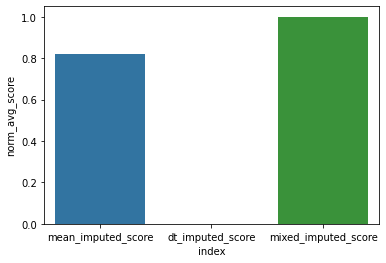

In [34]:
sns.barplot('index','norm_avg_score',data = imputation_cv_scores)

<a id="final_analysis"></a>
### Analysis
* It can be observed that the RMSE value is minimum for Decision Tree imputed Dataframe.
* We didn't go for any hyper-parameter tuning.
* Also we couldn't try much of Iterative Imputation because of RAM issues in google Colab as well as my personal desktop.
* After several days of finding out which parameters could actually decrease the RAM usage we were able to run some decent experiments on imputation.
* There are two set of parameters to control
  * Hyper-parameters of the model which is going to impute the dataframe.
  * Hyper-paramters of the Iterative and Simple Imputer which have parameters like max_iteration and tolerance.
  * If the imputation converges before the max_iteration then well and good otherwise it uses up the entire RAM.

## 8. Imputing columns for new merchant transactions based on our observations above


In [4]:
trans_new_df = pickle.load(open('trans_new_df.pkl','rb'))
impute_new_trans_col = pickle.load(open('selected_cols_from_new_trans.pkl','rb'))

### 8.1 Using Decision Tree based imputer
* Since it performed better than all the remaining imputations

In [5]:
print("Creating Decision Tree Regressor...")
dt_regressor = DecisionTreeRegressor(max_features='sqrt',
                                     max_depth=5,
                                     random_state=0)
print("Creating Iterative Imputer...")
iterative_imputer = IterativeImputer(random_state = 0,
                                     estimator = dt_regressor,
                                     tol = 0.1,
                                     verbose=30)

Creating Decision Tree Regressor...
Creating Iterative Imputer...


### 8.2  Dropping the unnecessary columns
* Dropping card_id and categorical mode features since they are useless for modelling
* Converting boolean features into 0's and 1's

In [8]:
X_train = trans_new_df[impute_new_trans_col]
X_features = X_train.drop(['card_id'],axis=1)

In [20]:
cat_cols = X_features.select_dtypes('O').columns.unique()
bool_cols = X_features.select_dtypes('bool').columns.unique()
print("Categorical columns : ",cat_cols)
print("Boolean columns : ",bool_cols)

## Mode features are useless
X_features.drop(cat_cols,axis=1,inplace=True)

## for boolean features converting them into 1's and 0's
for col in bool_cols:
    X_features[col] = X_features[col].apply(lambda x : 1 if True else 0)

Categorical columns :  Index(['category_1_mode', 'category_3_mode'], dtype='object')
Boolean columns :  Index(['is_purchase_month_end_mode', 'is_purchase_month_end_min',
       'is_purchase_month_start_mode', 'is_purchase_month_start_min',
       'is_purchase_quarter_start_mode', 'is_purchase_quarter_start_min',
       'is_purchase_quarter_end_mode', 'is_purchase_quarter_end_min',
       'is_purchase_year_end_mode', 'is_purchase_year_end_min',
       'is_purchase_year_start_mode', 'is_purchase_year_start_min',
       'is_christmas_mode', 'is_christmas_min', 'is_mothers_day_mode',
       'is_mothers_day_min', 'is_childrens_day_mode', 'is_childrens_day_min',
       'is_valentines_day_mode', 'is_valentines_day_min',
       'is_fathers_day_mode', 'is_fathers_day_min'],
      dtype='object')


### 8.3 replacing infinity values by nan's

In [23]:
X_features.replace([np.inf,-np.inf],np.nan,inplace=True)

In [24]:
print("Imputing features...")
dt_imputed_features = iterative_imputer.fit_transform(X_features)
dt_imputed_df = pd.DataFrame(dt_imputed_features,columns=X_features.columns)

Imputing features...
[IterativeImputer] Completing matrix with shape (179986, 199)
[IterativeImputer] Ending imputation round 1/10, elapsed time 480.26
[IterativeImputer] Change: 6820.386680822434, scaled tolerance: 843.2 
[IterativeImputer] Ending imputation round 2/10, elapsed time 967.46
[IterativeImputer] Change: 5893.547782301697, scaled tolerance: 843.2 
[IterativeImputer] Ending imputation round 3/10, elapsed time 1458.23
[IterativeImputer] Change: 5448.720516115342, scaled tolerance: 843.2 
[IterativeImputer] Ending imputation round 4/10, elapsed time 1939.31
[IterativeImputer] Change: 4315.096195200879, scaled tolerance: 843.2 
[IterativeImputer] Ending imputation round 5/10, elapsed time 2432.11
[IterativeImputer] Change: 3924.975576559918, scaled tolerance: 843.2 
[IterativeImputer] Ending imputation round 6/10, elapsed time 2922.11
[IterativeImputer] Change: 3179.642601784601, scaled tolerance: 843.2 
[IterativeImputer] Ending imputation round 7/10, elapsed time 3410.20
[It

c:\users\capiot\appdata\local\programs\python\python36\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


### 8.4 Add card_id column and target column
* So that we can use it for feature selection purpose


In [26]:
dt_imputed_df.shape

(179986, 199)

In [27]:
dt_imputed_df = pd.concat([X_train['card_id'],dt_imputed_df],axis=1)
dt_imputed_df.shape

(179986, 200)

In [29]:
trans_train_df = pickle.load(open('trans_train_df.pkl','rb'))
dt_imputed_df = pd.merge(trans_train_df[['card_id','target']],dt_imputed_df,on='card_id',how='inner')
dt_imputed_df.shape

(179986, 201)

In [30]:
pickle.dump(dt_imputed_df,open('feature_set_4.pkl','wb'))